In [14]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42)
torch.manual_seed(42)

num_cycles = 15000
num_samples = num_cycles

driving_patterns = np.random.choice([0, 1, 2], size=num_samples, p=[0.3, 0.45, 0.25])
charging_patterns = np.random.choice([0, 1, 2], size=num_samples, p=[0.3, 0.45, 0.25])
temperatures = np.random.normal(loc=25, scale=5, size=num_samples)
DoD = np.random.uniform(50, 100, size=num_samples)
trip_length = np.random.normal(loc=50, scale=20, size=num_samples)
cycles = np.arange(num_samples)

SoH = np.zeros(num_samples)
FCR = np.zeros(num_samples)
SoH[0] = 100.0
base_range = 500

k_base = [0.8, 1.0, 1.2]
charging_effect = [0.9, 1.0, 1.2]
temp_effect = lambda T: 1 + 0.005*(T-25)
dod_effect = lambda d: 1 + 0.002*(d-80)
trip_effect = lambda t: 1 + 0.001*(t-50)
base_degradation_rate = 0.0025
knee_threshold = 70.0
knee_severity = 0.03

for i in range(1, num_samples):
    dp = driving_patterns[i]
    cp = charging_patterns[i]
    temp = temperatures[i]
    dod = DoD[i]
    trip = trip_length[i]
    
    degradation_step = (base_degradation_rate * k_base[dp] * charging_effect[cp] * \
                        dod_effect(dod) * trip_effect(trip) * temp_effect(temp))
    
    if SoH[i-1] < knee_threshold:
        acceleration_factor = 1 + (knee_threshold - SoH[i-1]) * knee_severity
        degradation_step *= acceleration_factor
    
    noise = np.random.normal(0, 0.00045)
    SoH[i] = np.clip(SoH[i-1] - degradation_step + noise, 20, 100)
    
    fcr_noise = np.random.normal(0, 1.5)
    FCR[i] = (base_range * (SoH[i]/100) * (1 - 0.02*dp) * temp_effect(temp) * (1 - 0.01*cp)) + fcr_noise

FCR[0] = base_range * (SoH[0]/100) * (1 - 0.02*driving_patterns[0]) * temp_effect(temperatures[0]) * \
         (1 - 0.01*charging_patterns[0])

df = pd.DataFrame({
    'cycle': cycles, 'temperature': temperatures, 'driving_pattern': driving_patterns,
    'charging_pattern': charging_patterns, 'DoD': DoD, 'trip_length_km': trip_length,
    'SoH': SoH, 'FCR': FCR
})

df.to_csv('battery_data.csv', index=False)
print("Data saved to 'battery_data.csv'")

Data saved to 'battery_data.csv'


In [15]:
df = pd.read_csv('mc_attention_data.csv')

print("Calculating Physics Constraints...")
base_range = 500
R0 = 0.05
alpha = 0.5
def temp_factor(T): return 1 + 0.005*(T-25)
def dod_factor(DoD): return 1 + 0.002*(DoD-80)
def trip_factor(trip): return 1 + 0.001*(trip-50)

SoH_phys = np.zeros(len(df))
FCR_phys = np.zeros(len(df))
SoH_phys[0] = 100.0

for i in range(1, len(df)):
    row = df.iloc[i]
    deg_step = (base_degradation_rate * k_base[int(row['driving_pattern'])] * \
                charging_effect[int(row['charging_pattern'])] * dod_factor(row['DoD']) * \
                trip_factor(row['trip_length_km']) * temp_factor(row['temperature']))
    if SoH_phys[i-1] < knee_threshold:
        deg_step *= (1 + (knee_threshold - SoH_phys[i-1]) * knee_severity)
    SoH_phys[i] = max(20, SoH_phys[i-1] - deg_step)
    FCR_phys[i] = base_range * (SoH_phys[i]/100) * (1 - 0.02*row['driving_pattern']) * \
                  temp_factor(row['temperature']) * (1 - 0.01*row['charging_pattern'])

df['SoH_phys'] = SoH_phys
df['FCR_phys'] = FCR_phys


feature_cols = ['cycle','temperature','driving_pattern','charging_pattern','DoD','trip_length_km']
target_cols = ['SoH','FCR']
phys_cols = ['SoH_phys', 'FCR_phys']

seq_len = 10
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

df[feature_cols] = feature_scaler.fit_transform(df[feature_cols])
df[target_cols] = target_scaler.fit_transform(df[target_cols].values)
df[phys_cols] = target_scaler.transform(df[phys_cols].values)


class EVBatteryDataset(Dataset):
    def __init__(self, df, seq_len=10):
        self.seq_len = seq_len
        self.features = df[feature_cols].values.astype(np.float32)
        self.targets = df[target_cols].values.astype(np.float32)
        self.physics = df[phys_cols].values.astype(np.float32)
    def __len__(self): return len(self.features) - self.seq_len
    def __getitem__(self, idx):
        return (torch.tensor(self.features[idx:idx+self.seq_len]), 
                torch.tensor(self.targets[idx+self.seq_len]), 
                torch.tensor(self.physics[idx+self.seq_len]))

dataset = EVBatteryDataset(df, seq_len)
train_size = int(0.8 * len(dataset))
train_loader = DataLoader(Subset(dataset, range(train_size)), batch_size=32, shuffle=True)
test_loader = DataLoader(Subset(dataset, range(train_size, len(dataset))), batch_size=32, shuffle=False)

Calculating Physics Constraints...


In [16]:
class HybridAttentionLSTM(nn.Module):
    def __init__(self, input_size=6, hidden_size=128, num_layers=1, output_size=2, dropout_prob=0.2):
        super(HybridAttentionLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_prob)
        self.attention_fc = nn.Linear(hidden_size, 1)
        self.fc1 = nn.Linear(hidden_size, 64)
        self.fc2 = nn.Linear(64, output_size)
        self.dropout = nn.Dropout(dropout_prob)
    
    def forward(self, x):
        lstm_out, _ = self.lstm(x) 
        attn_weights = F.softmax(self.attention_fc(lstm_out), dim=1) 
        context = torch.sum(lstm_out * attn_weights, dim=1) 
        out = F.relu(self.fc1(context))
        out = self.dropout(out)
        return self.fc2(out)

def physics_loss(y_pred, y_true, phys, prev_y_pred=None, lambda_mono=0.5):
    mse = nn.MSELoss()(y_pred, y_true)
    fcr_penalty = torch.mean(torch.clamp(y_pred[:, 1] - phys[:, 1], min=0))
    
    mono_penalty = 0
    if prev_y_pred is not None:
        
        diff = y_pred[:, 0] - prev_y_pred[:, 0]
        mono_penalty = torch.mean(torch.clamp(diff, min=0))
        
    return mse + (0.1 * fcr_penalty) + (lambda_mono * mono_penalty)


device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Training on {device}...")
model = HybridAttentionLSTM().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(180):
    model.train()
    total_loss = 0
    for x, y, phys in train_loader:
        x, y, phys = x.to(device), y.to(device), phys.to(device)
        optimizer.zero_grad()
        loss = physics_loss(model(x), y, phys)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    if (epoch+1) % 30 == 0:
        print(f"Epoch {epoch+1}/180, Loss: {total_loss/len(train_loader):.4f}")

Training on cuda...


c:\Jai's work\Softwares\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 30/180, Loss: 0.0032
Epoch 60/180, Loss: 0.0032
Epoch 90/180, Loss: 0.0032
Epoch 120/180, Loss: 0.0032
Epoch 150/180, Loss: 0.0032
Epoch 180/180, Loss: 0.0031


In [17]:
def predict_with_uncertainty(model, input_tensor, n_samples=50):
    model.train() 
    outputs = []
    with torch.no_grad():
        for _ in range(n_samples):
            outputs.append(model(input_tensor).unsqueeze(0))
    outputs = torch.cat(outputs, dim=0)
    return outputs.mean(dim=0), outputs.std(dim=0)

print("Running Monte Carlo Inference...")
features_tensor = torch.tensor(df[feature_cols].values, dtype=torch.float32).to(device)
all_means, all_stds = [], []
batch_size = 1000

for i in range(seq_len, len(df), batch_size):
    end = min(i + batch_size, len(df))
    batch_input = torch.stack([features_tensor[j-seq_len:j] for j in range(i, end)])
    mean, std = predict_with_uncertainty(model, batch_input, n_samples=30)
    all_means.append(mean.cpu().numpy())
    all_stds.append(std.cpu().numpy())

pred_means = target_scaler.inverse_transform(np.concatenate(all_means, axis=0))
pred_stds = np.concatenate(all_stds, axis=0) / target_scaler.scale_ # Approximate scale

Running Monte Carlo Inference...


In [18]:
y_true_unscaled = target_scaler.inverse_transform(df[target_cols].values)[seq_len:]

mae_soh = mean_absolute_error(y_true_unscaled[:, 0], pred_means[:, 0])
r2_soh = r2_score(y_true_unscaled[:, 0], pred_means[:, 0])

mae_fcr = mean_absolute_error(y_true_unscaled[:, 1], pred_means[:, 1])
r2_fcr = r2_score(y_true_unscaled[:, 1], pred_means[:, 1])

print("-" * 30)
print(f"Hybrid Attention LSTM Evaluation:")
print(f"SoH -> MAE: {mae_soh:.4f}, R2: {r2_soh:.4f}")
print(f"FCR -> MAE: {mae_fcr:.4f}, R2: {r2_fcr:.4f}")
print("-" * 30)

------------------------------
Hybrid Attention LSTM Evaluation:
SoH -> MAE: 0.6787, R2: 0.9945
FCR -> MAE: 10.4734, R2: 0.9414
------------------------------


In [19]:
cycles_unscaled_for_reporting = df['cycle'].values[seq_len:]

model.eval()
pred_results = []

features_tensor = torch.tensor(df[feature_cols].values, dtype=torch.float32).to(device)


with torch.no_grad():

    for i in range(seq_len, len(df)):
        x_seq = features_tensor[i-seq_len:i].unsqueeze(0)
        y_pred = model(x_seq)
        pred_results.append(y_pred[0].cpu().numpy())

pred_results = np.array(pred_results)
pred_unscaled = target_scaler.inverse_transform(pred_results)


cycles = cycles_unscaled_for_reporting
pred_df = pd.DataFrame({
    'cycle': cycles,
    'SoH_pred': pred_unscaled[:,0],
    'FCR_pred': pred_unscaled[:,1]
})

target_soh = [100, 90, 80, 70, 60]
table = []
for soh in target_soh:
    row = pred_df.iloc[(pred_df['SoH_pred'] - soh).abs().argsort()[:1]]
    table.append({
        'Target SoH (%)': soh,
        'Predicted SoH (%)': round(float(row['SoH_pred']),2),
        'Predicted Full-Charge Range (km)': round(float(row['FCR_pred']),2),
        'Cycle': int(row['cycle'])
    })

results_df = pd.DataFrame(table)
print("\nPredicted Range Table")
print(results_df)


Predicted Range Table
   Target SoH (%)  Predicted SoH (%)  Predicted Full-Charge Range (km)  Cycle
0             100              100.0                            477.42      0
1              90               90.0                            429.70      0
2              80               80.0                            381.19      0
3              70               70.0                            330.69      0
4              60               62.9                            294.84      0


C:\Users\Jai\AppData\Local\Temp\ipykernel_6108\3589110102.py:33: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  'Predicted SoH (%)': round(float(row['SoH_pred']),2),
C:\Users\Jai\AppData\Local\Temp\ipykernel_6108\3589110102.py:34: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  'Predicted Full-Charge Range (km)': round(float(row['FCR_pred']),2),
C:\Users\Jai\AppData\Local\Temp\ipykernel_6108\3589110102.py:35: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  'Cycle': int(row['cycle'])
C:\Users\Jai\AppData\Local\Temp\ipykernel_6108\3589110102.py:33: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  'Predicted SoH

In [20]:
import shap

X_sample = df[feature_cols].iloc[seq_len:110].values.astype(np.float32)


def model_predict_last_step(input_np):

    seq_input = np.repeat(input_np[:, np.newaxis, :], seq_len, axis=1)
    input_tensor = torch.tensor(seq_input, dtype=torch.float32).to(device)
    with torch.no_grad():
        out = model(input_tensor)
    return out[:, 0].cpu().numpy()

explainer = shap.KernelExplainer(model_predict_last_step, X_sample)
shap_values = explainer.shap_values(X_sample)


feature_importance = np.mean(np.abs(shap_values), axis=0)
shap_df = pd.DataFrame({
    'Feature': feature_cols,
    'Importance (mean abs SHAP)': feature_importance
}).sort_values(by='Importance (mean abs SHAP)', ascending=False)


print("\nSHAP Feature Importance")
print(shap_df)

  0%|          | 0/100 [00:00<?, ?it/s]


SHAP Feature Importance
            Feature  Importance (mean abs SHAP)
3  charging_pattern                    0.005491
2   driving_pattern                    0.005072
4               DoD                    0.003557
5    trip_length_km                    0.002118
0             cycle                    0.001522
1       temperature                    0.001383


In [21]:
pred_df['SoH_diff'] = pred_df['SoH_pred'].diff().fillna(0)
pred_df['Degradation_perc_per_cycle'] = -pred_df['SoH_diff']

avg_degradation = pred_df['Degradation_perc_per_cycle'].mean()

degradation_df = pd.DataFrame({
    'Metric': ['Average Degradation per cycle (%)'],
    'Value': [avg_degradation]
})

print("\n--- Degradation Analysis ---")
print(degradation_df)

top_degradation_df = pred_df[['cycle','SoH_pred','Degradation_perc_per_cycle']].sort_values(
    by='Degradation_perc_per_cycle', ascending=False
).head(10)

print("\nTop 10 cycles with highest degradation:")
print(top_degradation_df)


--- Degradation Analysis ---
                              Metric    Value
0  Average Degradation per cycle (%)  0.00246

Top 10 cycles with highest degradation:
         cycle   SoH_pred  Degradation_perc_per_cycle
149   0.010601  98.107132                    3.773987
2417  0.161811  92.499596                    2.953583
230   0.016001  97.422462                    2.553940
921   0.062071  96.113853                    2.496628
478   0.032536  96.488647                    2.449783
873   0.058871  96.850800                    2.338974
216   0.015068  97.591324                    2.305588
378   0.025868  96.889343                    2.170586
305   0.021001  97.695030                    2.154785
3803  0.254217  89.072136                    2.142456


Saved plots: advanced_soh_uncertainty.png, advanced_fcr_uncertainty.png


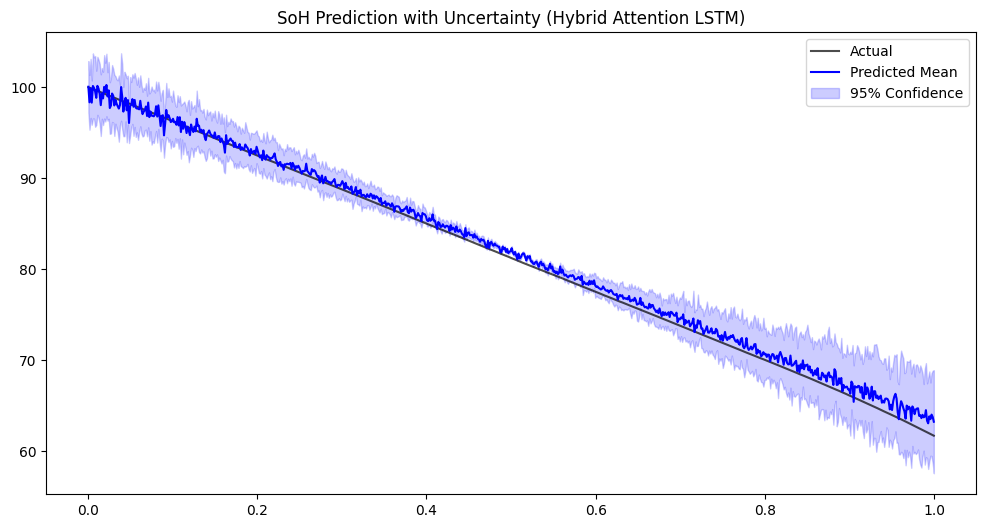

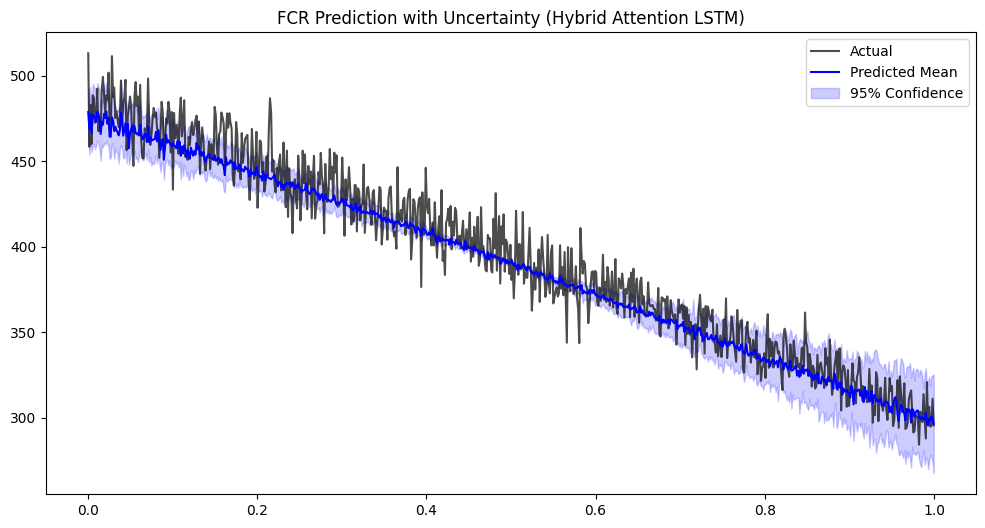

In [22]:
plot_df = pd.DataFrame({
    'cycle': df['cycle'].values[seq_len:],
    'SoH_true': target_scaler.inverse_transform(df[target_cols].values)[seq_len:, 0],
    'FCR_true': target_scaler.inverse_transform(df[target_cols].values)[seq_len:, 1],
    'SoH_pred': pred_means[:, 0], 'SoH_std': pred_stds[:, 0],
    'FCR_pred': pred_means[:, 1], 'FCR_std': pred_stds[:, 1]
})

plot_df_sampled = plot_df.iloc[::20, :]

plt.figure(figsize=(12, 6))
plt.plot(plot_df_sampled['cycle'], plot_df_sampled['SoH_true'], 'k', alpha=0.7, label='Actual')
plt.plot(plot_df_sampled['cycle'], plot_df_sampled['SoH_pred'], 'b', label='Predicted Mean')
plt.fill_between(plot_df_sampled['cycle'], 
                 plot_df_sampled['SoH_pred'] - 2*plot_df_sampled['SoH_std'],
                 plot_df_sampled['SoH_pred'] + 2*plot_df_sampled['SoH_std'],
                 color='b', alpha=0.2, label='95% Confidence')
plt.title('SoH Prediction with Uncertainty (Hybrid Attention LSTM)')
plt.legend()
plt.savefig('advanced_soh_uncertainty.png', dpi=300)

plt.figure(figsize=(12, 6))
plt.plot(plot_df_sampled['cycle'], plot_df_sampled['FCR_true'], 'k', alpha=0.7, label='Actual')
plt.plot(plot_df_sampled['cycle'], plot_df_sampled['FCR_pred'], 'b', label='Predicted Mean')
plt.fill_between(plot_df_sampled['cycle'], 
                 plot_df_sampled['FCR_pred'] - 2*plot_df_sampled['FCR_std'],
                 plot_df_sampled['FCR_pred'] + 2*plot_df_sampled['FCR_std'],
                 color='b', alpha=0.2, label='95% Confidence')
plt.title('FCR Prediction with Uncertainty (Hybrid Attention LSTM)')
plt.legend()
plt.savefig('advanced_fcr_uncertainty.png', dpi=300)

print("Saved plots: advanced_soh_uncertainty.png, advanced_fcr_uncertainty.png")

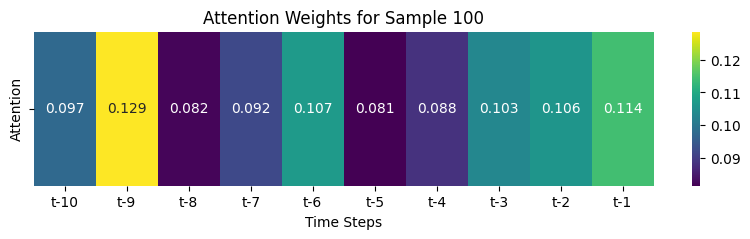

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch

def plot_attention_heatmap(model, dataset, sample_idx=0):
    model.eval()
    
    x, y, phys = dataset[sample_idx]
    x_input = x.unsqueeze(0).to(device)
    
    with torch.no_grad():
        lstm_out, _ = model.lstm(x_input)
        
        attn_scores = model.attention_fc(lstm_out)
        attn_weights = torch.nn.functional.softmax(attn_scores, dim=1)
        
        weights_np = attn_weights.squeeze().cpu().numpy()
        
    plt.figure(figsize=(10, 2))
    sns.heatmap(weights_np.reshape(1, -1), cmap='viridis', annot=True, fmt=".3f",
                xticklabels=[f"t-{len(weights_np)-i}" for i in range(len(weights_np))],
                yticklabels=["Attention"])
    plt.title(f"Attention Weights for Sample {sample_idx}")
    plt.xlabel("Time Steps")
    plt.show()

plot_attention_heatmap(model, dataset, sample_idx=100)